In [1]:
import pandas as pd
df = pd.read_csv("raw_data/ustc_historic_data.csv", sep=";")
df.head()
df.columns

Index(['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 'open', 'high',
       'low', 'close', 'volume', 'marketCap', 'circulatingSupply',
       'timestamp'],
      dtype='object')

In [2]:
# clean datetime predictors
time_cols = ["timeOpen", "timeClose", "timeHigh", "timeLow", "timestamp"]
df[time_cols] = df[time_cols].apply(pd.to_datetime)

# standardise date reference 
df["date"] = df["timestamp"].dt.normalize()

df = df.drop(columns=time_cols)

In [3]:
# setting up predictors
import numpy as np

# sort and index date
df = df.sort_values('date').set_index('date')
df = df.asfreq('D', method='ffill') 

In [4]:
# 1. PRICE DEVIATION FROM $1
df['price_dev'] = df['close'] - 1
df['abs_price_dev'] = abs(df['price_dev'])
df['rel_price_dev'] = df['price_dev'] / 1

In [5]:
# 2. PRICE VOLATILITY / DAILY SWINGS
df['intraday_range_pct'] = (df['high'] - df['low']) / df['close']  # daily swing
df['volatility_7d'] = df['close'].pct_change().rolling(7).std()     # rolling 7-day volatility

In [6]:
# 3. VOLUME / LIQUIDITY STRESS
df['volume_zscore'] = (df['volume'] - df['volume'].rolling(7).mean()) / df['volume'].rolling(20).std()
df['volume_acceleration'] = df['volume_zscore'].diff().rolling(3).mean()
df['turnover'] = df['volume'] / df['circulatingSupply']
df['range_expansion'] = df['intraday_range_pct'] / df['intraday_range_pct'].rolling(7).mean()
# Optional: df['volume_chg'] = df['volume'].pct_change()
# Optional: df['volume_ma7'] = df['volume'].rolling(7).mean()
# Optional: df['price_range_proxy'] = df['intraday_range_pct']

In [7]:
# 4. SUPPLY & MARKET CAP CHANGES
df['supply_chg'] = df['circulatingSupply'].pct_change()
df['mcap_chg'] = df['marketCap'].pct_change()
df['mcap_velocity'] = df['marketCap'].pct_change(3)
df['supply_panic'] = (df['circulatingSupply'].pct_change().abs() > 0.05)
df['volume_mcap_ratio'] = df['volume'] / df['marketCap']

In [8]:
#5. EARLY WARNING / ACCELERATION SIGNALS
df['dev_acceleration'] = df['abs_price_dev'].diff().rolling(3).mean()
df['peg_stable_days'] = (df['close'] > 0.999).astype(int).groupby(
    (df['close'] <= 0.999).astype(int).cumsum()
).cumsum()
df['peg_breakdown'] = df['peg_stable_days'].diff().fillna(0)
df['price_shock'] = (abs(df['close'].pct_change()) > 0.02).astype(int)
df['volume_explosion'] = (df['volume'] > df['volume'].rolling(30).quantile(0.95)).astype(int)


In [9]:
df.head()

,name,open,high,low,close,volume,marketCap,circulatingSupply,price_dev,abs_price_dev,...,supply_chg,mcap_chg,mcap_velocity,supply_panic,volume_mcap_ratio,dev_acceleration,peg_stable_days,peg_breakdown,price_shock,volume_explosion
date,,,,,,,,,,,,,,,,,,,,,
2021-12-28 00:00:00+00:00,2781,1.000560,1.003111,0.999108,1.002239,1.395190e+08,1.005642e+10,1.003396e+10,0.002239,0.002239,...,NaN,NaN,NaN,False,0.013874,NaN,1,0.0,0,0
2021-12-29 00:00:00+00:00,2781,1.002244,1.003347,0.999270,1.001423,1.575926e+08,1.007944e+10,1.006511e+10,0.001423,0.001423,...,0.003105,0.002289,NaN,False,0.015635,NaN,2,1.0,0,0
2021-12-30 00:00:00+00:00,2781,1.001019,1.002950,0.999730,1.001984,1.106219e+08,1.011771e+10,1.009768e+10,0.001984,0.001984,...,0.003235,0.003797,NaN,False,0.010933,NaN,3,1.0,0,0
2021-12-31 00:00:00+00:00,2781,1.001748,1.002327,0.998924,1.001440,1.357036e+08,1.013712e+10,1.012254e+10,0.001440,0.001440,...,0.002463,0.001918,0.008024,False,0.013387,-0.000266,4,1.0,0,0
2022-01-01 00:00:00+00:00,2781,1.001657,1.002204,0.998407,1.000757,1.266358e+08,1.013354e+10,1.012587e+10,0.000757,0.000757,...,0.000329,-0.000353,0.005367,False,0.012497,-0.000222,5,1.0,0,0


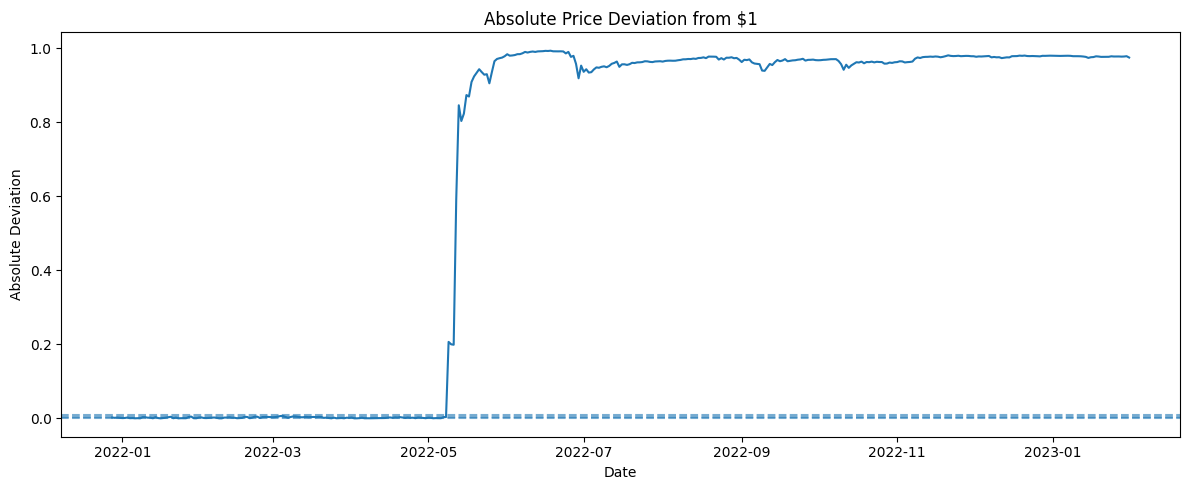

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df.index, df['abs_price_dev'])

plt.axhline(0.001, linestyle='--', alpha=0.6)
plt.axhline(0.003, linestyle='--', alpha=0.6)
plt.axhline(0.01, linestyle='--', alpha=0.6)

plt.title('Absolute Price Deviation from $1')
plt.xlabel('Date')
plt.ylabel('Absolute Deviation')
plt.tight_layout()
plt.show()  # shows inline in the notebook


In [11]:
#setting pre crash crash and post crash regimes
#thresholds
depeg_thresh = 0.01 
pre_crash_window = 7

#crash days
df['is_crash'] = (abs(df['close'] - 1) > depeg_thresh).astype(int)
crash_start = df[df['is_crash'] == 1].index.min()
pre_crash_start = crash_start - pd.Timedelta(days=pre_crash_window)
crash_end = df[df.index >= crash_start][df['is_crash'] == 1].index.max()
post_crash_end = crash_end + pd.Timedelta(days=7)

/var/folders/t3/4f3r77m96393n7bqz6cbqc980000gn/T/ipykernel_18540/845440854.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  crash_end = df[df.index >= crash_start][df['is_crash'] == 1].index.max()


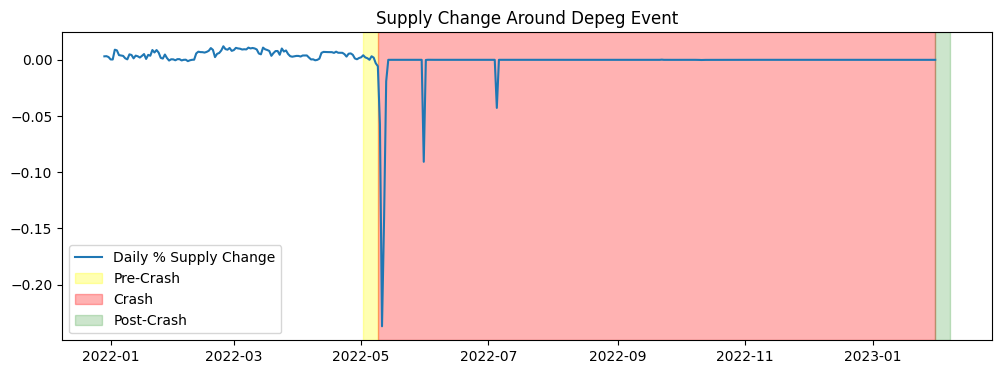

In [12]:
#observe supply change
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(df.index, df['supply_chg'], label='Daily % Supply Change')
plt.axvspan(pre_crash_start, crash_start, color='yellow', alpha=0.3, label='Pre-Crash')
plt.axvspan(crash_start, crash_end, color='red', alpha=0.3, label='Crash')
plt.axvspan(crash_end, post_crash_end, color='green', alpha=0.2, label='Post-Crash')
plt.legend()
plt.title("Supply Change Around Depeg Event")
plt.show()

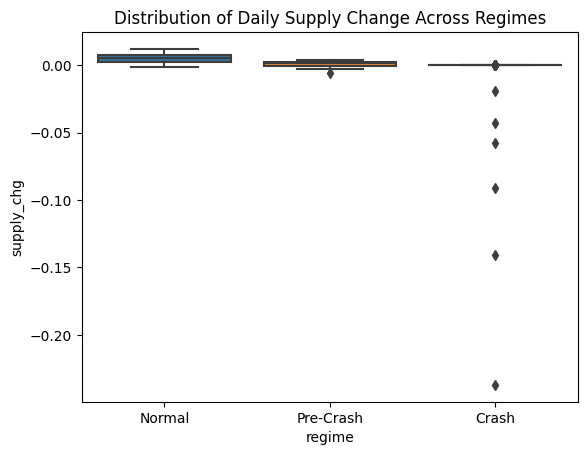

In [13]:
#compare before and after crash
import seaborn as sns

import numpy as np

df['regime'] = np.where(df.index < crash_start, 'Normal',
                        np.where(df.index <= crash_end, 'Crash',
                                 'Post-Crash'))
df.loc[pre_crash_start:crash_start, 'regime'] = 'Pre-Crash'


sns.boxplot(x='regime', y='supply_chg', data=df) 
plt.title("Distribution of Daily Supply Change Across Regimes")
plt.show()

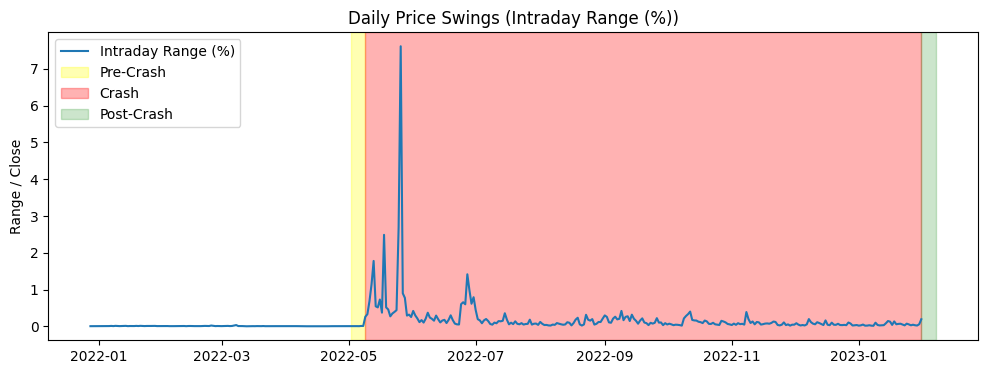

In [14]:
#tracking instability of price process before the peg breaks

##daily swings
plt.figure(figsize=(12,4))
plt.plot(df.index,
         df['intraday_range_pct'], label = 'Intraday Range (%)')

plt.axvspan(pre_crash_start, crash_start, color = 'yellow', alpha=0.3, label = 'Pre-Crash')
plt.axvspan(crash_start, crash_end, color = 'red', alpha=0.3, label = 'Crash')
plt.axvspan(crash_end, post_crash_end, color = 'green', alpha=0.2, label = 'Post-Crash')

plt.title("Daily Price Swings (Intraday Range (%))")
plt.ylabel("Range / Close")
plt.legend()
plt.show()

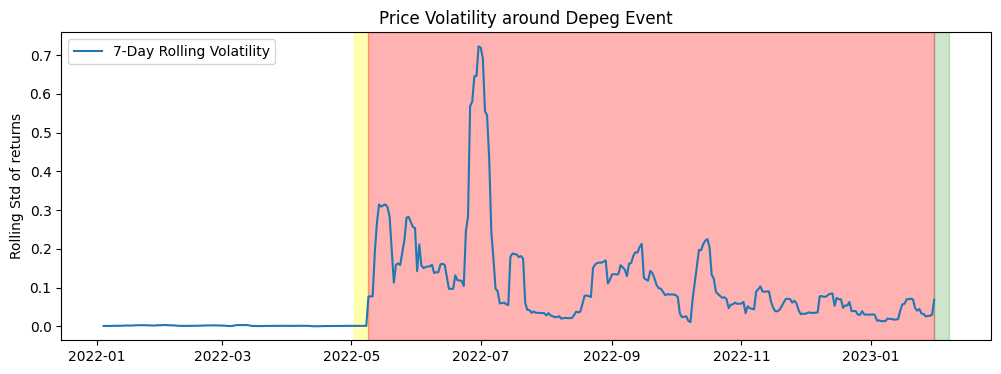

In [15]:
##rolling volatility

plt.figure(figsize=(12,4))
plt.plot(df.index, df['volatility_7d'], label = '7-Day Rolling Volatility')
plt.axvspan(pre_crash_start, crash_start, color = 'yellow', alpha=0.3)
plt.axvspan(crash_start, crash_end, color = 'red', alpha=0.3)
plt.axvspan(crash_end, post_crash_end, color = 'green', alpha=0.2)

plt.title("Price Volatility around Depeg Event")
plt.ylabel("Rolling Std of returns")
plt.legend()
plt.show()